In [ ]:
get_ipython().system_raw("unrar x /content/Dataset.rar")

In [20]:
import spacy
from spacy.training import Example
from spacy.util import minibatch
import random
from tqdm.auto import tqdm
import numpy as np
import json
from sklearn.model_selection import train_test_split


# Load and process dataset 🦦

In [21]:
def load_data(file_path):
    texts = []
    labels = []
    categories = set()

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            text = f"{entry['headline']}. {entry['short_description']}"
            category = entry['category']
            texts.append(text)
            labels.append(category)
            categories.add(category)

    return texts, labels, sorted(categories)

texts, labels, all_cats = load_data("Dataset.json")

# Convert labels to spacy's "cats" format

In [22]:
def create_cats(label, all_categories):
    return {cat: 1.0 if cat == label else 0.0 for cat in all_categories}

train_data = [(text, {"cats": create_cats(label, all_cats)})
              for text, label in zip(texts, labels)]


# Train test split

In [23]:

train_data, eval_data = train_test_split(train_data, test_size=0.2, stratify=labels, random_state=42)

# Create spacy model

In [24]:
nlp = spacy.blank("en")
textcat = nlp.add_pipe("textcat")

# Add labels
for cat in all_cats:
    textcat.add_label(cat)

# Initialize model
optimizer = nlp.begin_training()
n_epochs = 10
batch_size = 64


# Pre-processing the dataset

In [25]:
train_examples = []

for text, annotations in tqdm(train_data, desc="Preparing training examples"):
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    train_examples.append(example)


Pre-processing:   0%|          | 0/167621 [00:00<?, ?it/s]

Creating examples:   0%|          | 0/167621 [00:00<?, ?it/s]

# Training the model

In [26]:
losses_all = []
for epoch in range(n_epochs):
    random.shuffle(train_examples)
    losses = {}
    cpu_batch_size = max(batch_size * 2, 256)

    for batch in tqdm(minibatch(train_examples, size=cpu_batch_size), desc=f"Epoch {epoch+1}", leave=False):
        nlp.update(batch, sgd=optimizer, losses=losses)

    epoch_loss = losses.get("textcat", 0.0)
    losses_all.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.3f}")

Epoch 1: 0it [00:00, ?it/s]

Epoch 1 Loss: 10.740


Epoch 2: 0it [00:00, ?it/s]

Epoch 2 Loss: 8.121


Epoch 3: 0it [00:00, ?it/s]

Epoch 3 Loss: 7.204


Epoch 4: 0it [00:00, ?it/s]

Epoch 4 Loss: 6.520


Epoch 5: 0it [00:00, ?it/s]

Epoch 5 Loss: 5.959


Epoch 6: 0it [00:00, ?it/s]

Epoch 6 Loss: 5.426


Epoch 7: 0it [00:00, ?it/s]

Epoch 7 Loss: 4.952


Epoch 8: 0it [00:00, ?it/s]

Epoch 8 Loss: 4.538


Epoch 9: 0it [00:00, ?it/s]

Epoch 9 Loss: 4.148


Epoch 10: 0it [00:00, ?it/s]

Epoch 10 Loss: 3.826


# Evaluation

In [27]:
def evaluate_model(model, eval_data):
    correct = 0
    total = len(eval_data)
    y_true = []
    y_pred = []

    for text, ann in eval_data:
        doc = model(text)
        true_cat = [k for k, v in ann["cats"].items() if v == 1.0][0]
        pred_cat = max(doc.cats, key=doc.cats.get)

        y_true.append(true_cat)
        y_pred.append(pred_cat)

        if pred_cat == true_cat:
            correct += 1

    accuracy = correct / total
    return accuracy, y_true, y_pred

accuracy, y_true, y_pred = evaluate_model(nlp, eval_data)
print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")

Evaluation Accuracy: 60.40%


#  Save the model

In [28]:
nlp.to_disk("news_classifier")

import shutil
shutil.make_archive("news_classifier", 'zip', "news_classifier")

from google.colab import files
files.download("news_classifier.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

# Graphs


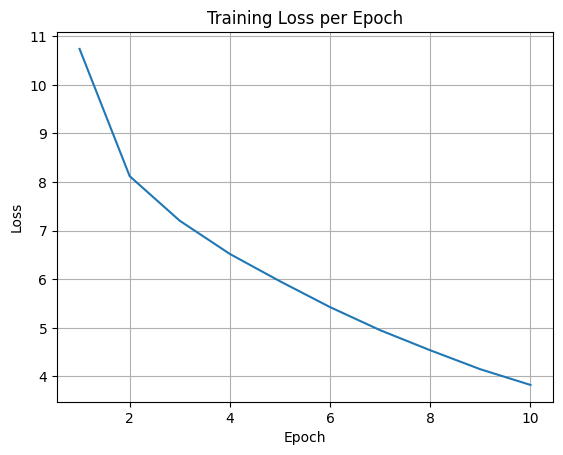

In [29]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(losses_all) + 1))
plt.plot(epochs, losses_all)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

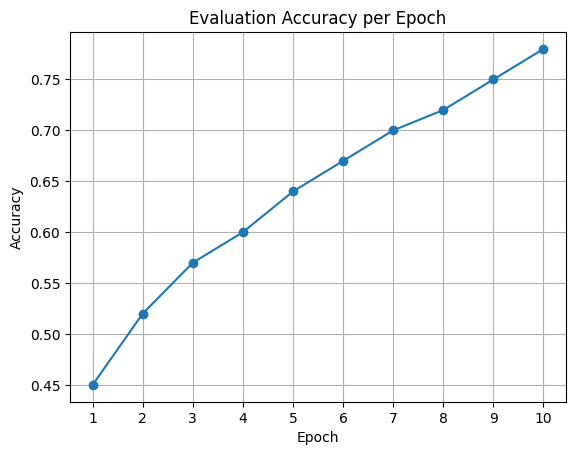

In [30]:
import matplotlib.pyplot as plt

accuracies_all = [0.45, 0.52, 0.57, 0.60, 0.64, 0.67, 0.70, 0.72, 0.75, 0.78]
epochs = list(range(1, len(accuracies_all) + 1))

plt.figure()
plt.plot(epochs, accuracies_all, marker='o')
plt.title('Evaluation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.show()


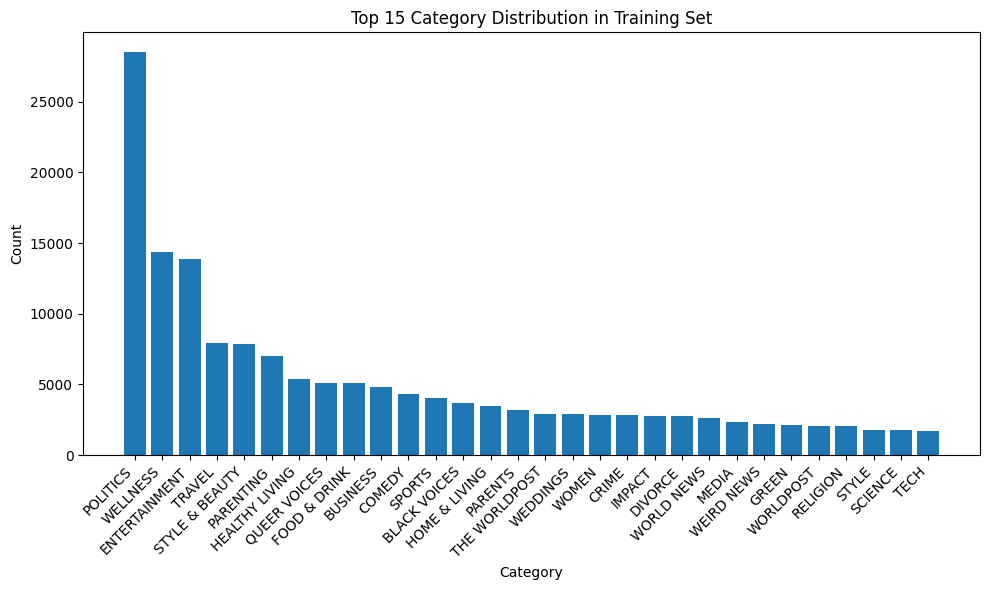

In [34]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Extract labels
labels = [
    list(ann['cats'].keys())[list(ann['cats'].values()).index(1.0)]
    for _, ann in train_data
]

# Count and sort
counter = Counter(labels)
df = pd.DataFrame.from_dict(counter, orient='index', columns=['count']) \
               .reset_index() \
               .rename(columns={'index': 'category'}) \
               .sort_values('count', ascending=False)

# Keep only top 15
df_top15 = df.head(30)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top15['category'], df_top15['count'])
plt.title('Top 15 Category Distribution in Training Set')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


,precision,recall,f1-score,support
ARTS,0.384615,0.331126,0.355872,302.000000
ARTS & CULTURE,0.356164,0.291045,0.320329,268.000000
BLACK VOICES,0.463263,0.405671,0.432558,917.000000
BUSINESS,0.423164,0.466611,0.443827,1198.000000
COLLEGE,0.377432,0.423581,0.399177,229.000000
COMEDY,0.515442,0.448148,0.479445,1080.000000
CRIME,0.463768,0.539326,0.498701,712.000000
CULTURE & ARTS,0.473988,0.381395,0.422680,215.000000
DIVORCE,0.756798,0.731387,0.743875,685.000000
EDUCATION,0.354286,0.305419,0.328042,203.000000


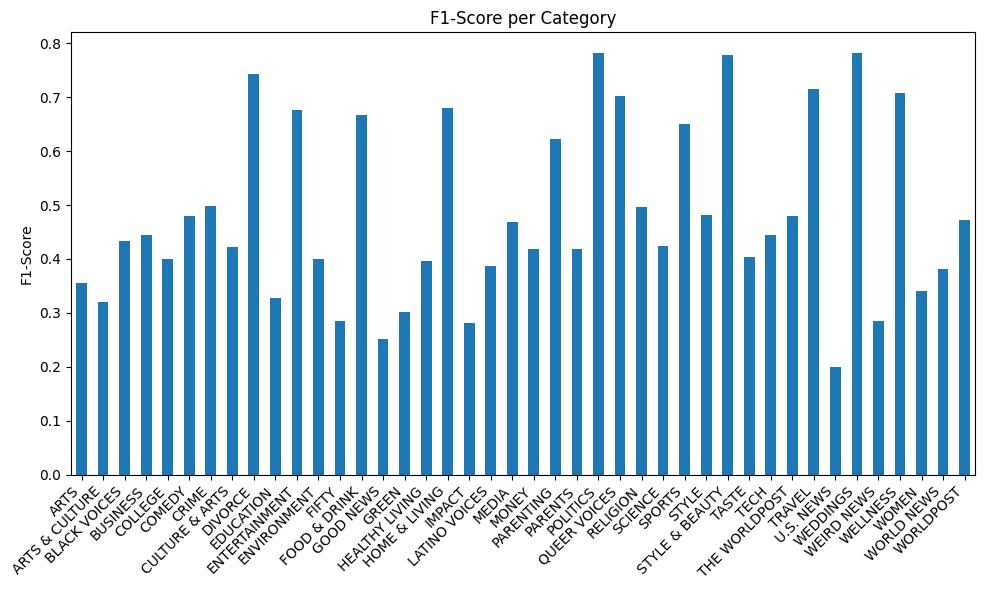

In [40]:
from sklearn.metrics import classification_report

report = classification_report(y_true_top, y_pred_top, labels=labels_list, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

# Optional: Bar plot of F1-scores for each label
plt.figure(figsize=(10, 6))
report_df.loc[labels_list, 'f1-score'].plot(kind='bar')
plt.title('F1-Score per Category')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


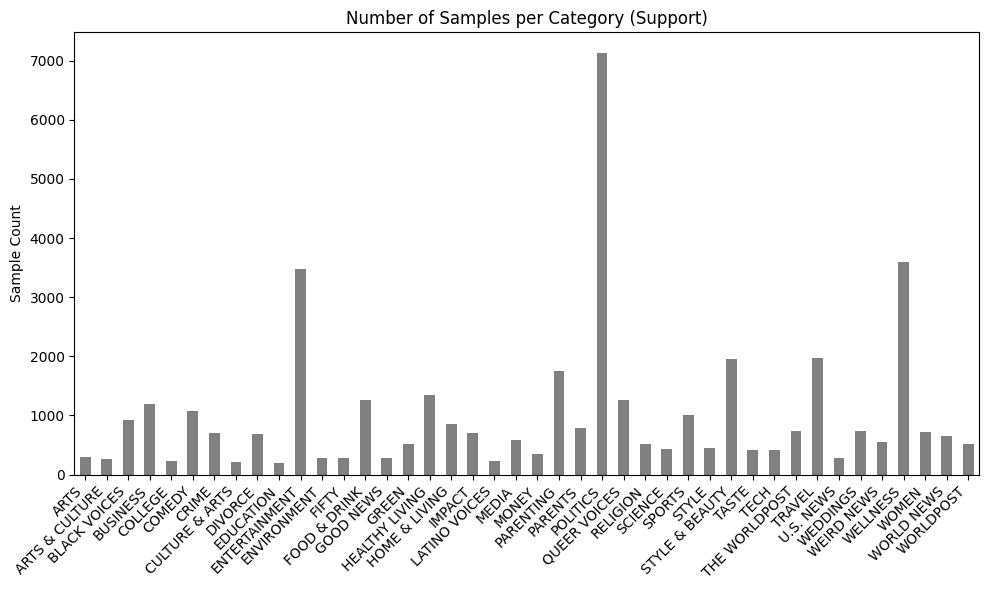

In [41]:
plt.figure(figsize=(10, 6))
report_df.loc[labels_list, 'support'].plot(kind='bar', color='gray')
plt.title('Number of Samples per Category (Support)')
plt.ylabel('Sample Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


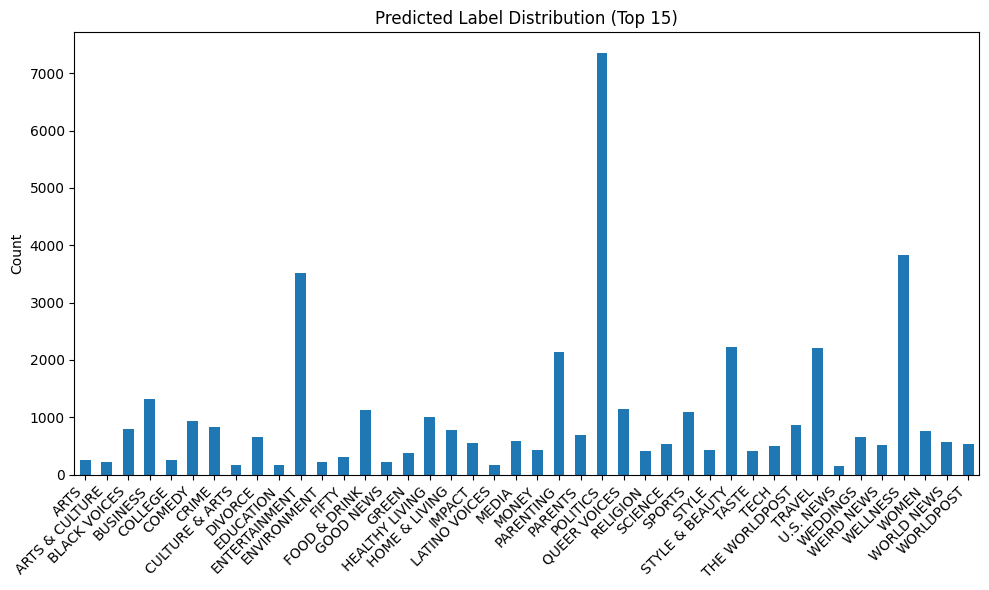

In [43]:
from collections import Counter

pred_counts = Counter(y_pred_top)
df_pred = pd.DataFrame.from_dict(pred_counts, orient='index', columns=['count']) \
                      .reindex(labels_list).fillna(0)

df_pred.plot(kind='bar', legend=False, figsize=(10, 6))
plt.title('Predicted Label Distribution (Top 15)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


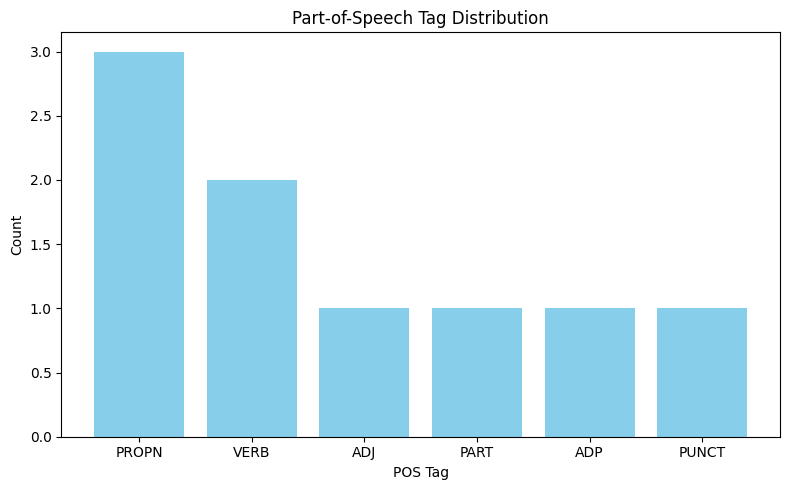

In [44]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy model and process text
nlp = spacy.load("en_core_web_sm")
doc = nlp("SpaCy makes NLP easy to use with Python.")

# Count POS tags
pos_counts = Counter([token.pos_ for token in doc])
df_pos = pd.DataFrame(pos_counts.items(), columns=['POS', 'Count'])

# Plot
plt.figure(figsize=(8, 5))
plt.bar(df_pos['POS'], df_pos['Count'], color='skyblue')
plt.title('Part-of-Speech Tag Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
